## 2022-10-2122 SN 2022vqz

Analysis by Brian

### Calibrate

We are using a slightly non-standard but pleasantly clean calibration procedure which requires
the lights and the darks to have the same exposure duration (typically of order 30s),
and the flats and the biases to have the same exposure duration (typically 1s). The more standard but less clean
procedure involves "scaling" the darks.

In [1]:
import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from ccdproc import ImageFileCollection, Combiner, combine, subtract_dark, flat_correct
from astropy.visualization import imshow_norm, PercentileInterval, MinMaxInterval, SqrtStretch
import matplotlib.pyplot as plt
%matplotlib inline
import astroalign as aa

In [2]:
observation_date = '2022-10-2425'
light_exposure = 30 * u.second
dark_exposure = light_exposure  # our method presumes this equality
flat_exposure = 1 * u.second
bias_exposure = flat_exposure  # our method presumes this equality
method = 'median'

In [3]:
data_directory = os.path.join(os.path.expanduser('~'), 'Transients', observation_date)

In [4]:
light_directory = os.path.join(data_directory, 'light')
dark_directory = os.path.join(data_directory, 'dark')
flat_directory = os.path.join(data_directory, 'flat')
bias_directory = os.path.join(data_directory, 'bias')

In [5]:
light_files = ImageFileCollection(light_directory).files_filtered(include_path='True')
dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')
flat_files = ImageFileCollection(flat_directory).files_filtered(include_path='True')
bias_files = ImageFileCollection(bias_directory).files_filtered(include_path='True')

In [6]:
lights = [CCDData.read(file, unit=u.adu) for file in light_files]
darks = [CCDData.read(file, unit=u.adu) for file in dark_files]
flats = [CCDData.read(file, unit=u.adu) for file in flat_files]
biases = [CCDData.read(file, unit=u.adu) for file in bias_files]

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


In [7]:
master_dark = combine(darks, method=method)
master_flat = combine(flats, method=method)
master_bias = combine(biases, method=method)

In [8]:
lights_subtracted = [subtract_dark(light,
                                   master_dark,
                                   data_exposure=light_exposure,
                                   dark_exposure=dark_exposure,
                                   scale=False)
                     for light in lights]

master_flat_subtracted = subtract_dark(master_flat,
                                       master_bias,
                                       data_exposure=flat_exposure,
                                       dark_exposure=bias_exposure,
                                       scale=False)

In [9]:
lights_calibrated = [flat_correct(l, master_flat_subtracted) for l in lights_subtracted]

/Applications/Anaconda/anaconda3/envs/transient/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Applications/Anaconda/anaconda3/envs/transient/lib/python3.9/site-packages/astropy/nddata/nduncertainty.py:684: RuntimeWarning: invalid value encountered in true_divide
  return from_variance((left + right + correlation_sign * corr) /


In [10]:
light = lights[0]

In [11]:
calibrated_light = lights_calibrated[0]

### Examine Calibration

Here we experiment with LogStretch and SqrtStretch from astropy.visualization to check that our calibrated images
have vignetting and the shadows of dust motes well-removed. Principally, we follow the recommendations in the [Image stretching and normalization](https://docs.astropy.org/en/stable/visualization/normalization.html) documentation from astropy.visualization.

Additionally, we may want to study a [notebook](https://github.com/viveikjha/aperture_photometry/blob/master/Reduction_demonstration.ipynb) by Vivek Kumar Jha from Aryabhatta Research Institute of Observational Sciences ([ARIES](https://www.aries.res.in)), and [another notebook](https://notebook.community/LSSTC-DSFP/LSSTC-DSFP-Sessions/Session5/Day1/python_imred) by Erik Tollerud from the Space Telescope Science Institute ([STScI](https://www.stsci.edu)).

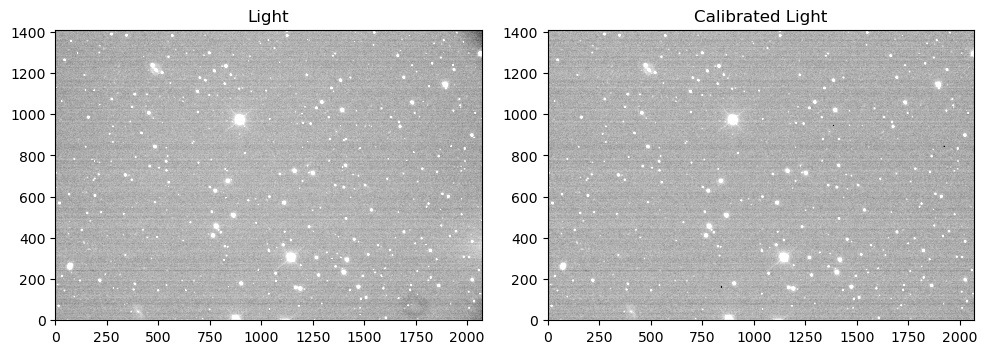

In [12]:
interval_95 = PercentileInterval(95)
sqrt_stretch=SqrtStretch()

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

im_l, norm_l = imshow_norm(light, axes[0], cmap='gray', origin='lower',
                       interval=interval_95, stretch=sqrt_stretch)
axes[0].set_title("Light")

im_c_l, norm_c_l = imshow_norm(calibrated_light, axes[1], cmap='gray', origin='lower',
                       interval=interval_95, stretch=sqrt_stretch)
axes[1].set_title("Calibrated Light")

plt.tight_layout()
plt.show()

### Alignment

From here on, we only have use for the calibrated lights. The next step is to align them.

In [13]:
from scipy.ndimage import rotate, zoom

In [14]:
image_to_rotate = lights_calibrated[1]

In [15]:
image_rotated = rotate(image_to_rotate, angle=30.0, reshape=False)

In [16]:
image_rotated_and_zoomed = zoom(image_rotated, 1.5, order=2)

In [27]:
# This attempt to rotate and zoom the lights_calibrate[1] is not working.
# lights_calibrated[1] = image_rotated_and_zoomed
lights_calibrated[1] = image_to_rotate

In [18]:
reference = lights_calibrated[0]

In [28]:
sources_aligned = [aa.register(s, reference, detection_sigma=3.0) for s in lights_calibrated]

### Examine Alignment

Let's examine the first aligned image in comparison with the reference image.

In [29]:
source = lights_calibrated[1]

In [30]:
source_aligned, footprint = sources_aligned[1]

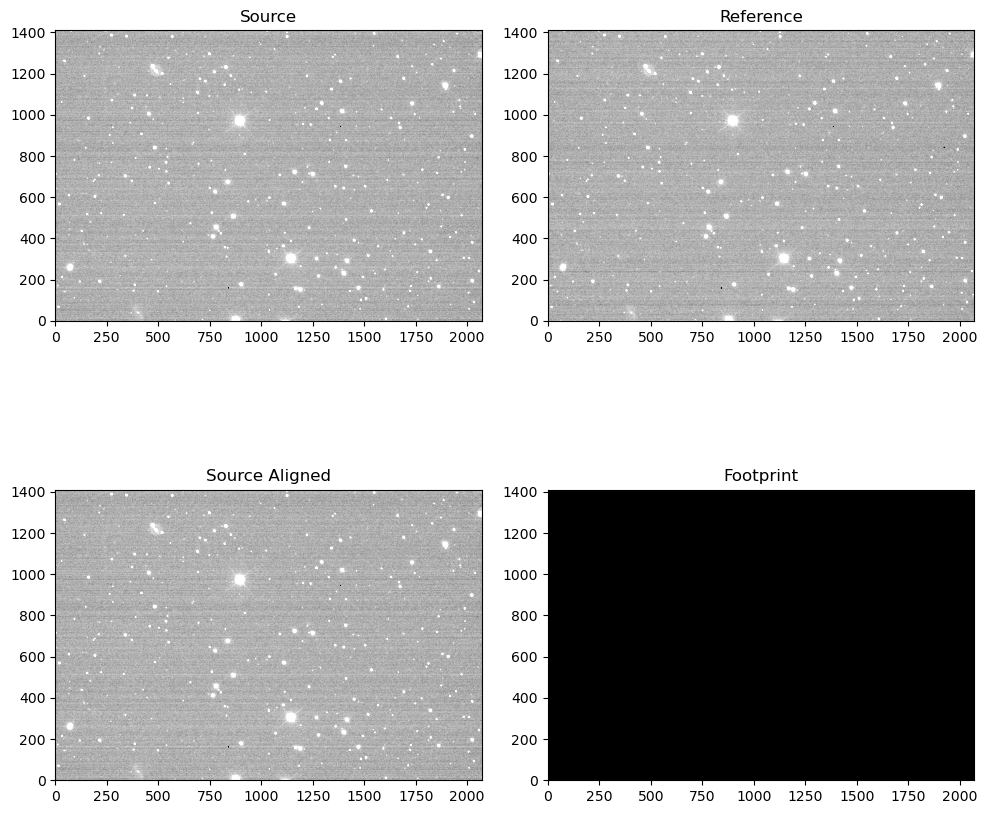

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

_, _ = imshow_norm(source, axes[0, 0], cmap='gray', origin='lower',
           interval=interval_95, stretch=SqrtStretch())
axes[0, 0].set_title("Source")

_, _ = imshow_norm(reference, axes[0, 1], cmap='gray', origin='lower',
           interval=interval_95, stretch=SqrtStretch())
axes[0, 1].set_title("Reference")

# axes[1, 0].imshow(img_aligned, cmap='gray', interpolation='none', origin='lower')
_, _ = imshow_norm(source_aligned, axes[1, 0], cmap='gray', origin='lower',
           interval=interval_95, stretch=SqrtStretch())
axes[1, 0].set_title("Source Aligned")

axes[1, 1].imshow(footprint, cmap='gray', interpolation='none', origin='lower')
axes[1, 1].set_title("Footprint")

plt.tight_layout()
plt.show()
